# TFM. Modelo predictivo llamadas Call Center
## MVP

## Importacion de librerias 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import datetime
import calendar

pd.options.display.max_columns = None

### Importacion de los datos de envios por oficinas

In [2]:
df_shippings = pd.read_csv('data/shippings.csv', low_memory=False)

In [3]:
df_shippings['Franquicia destino'].unique()

array([4800, 4802, 4803, 4806, 4810])

##### Filtramos oficinas

In [4]:
#df = df_shippings[ (df_shippings['Franquicia destino']==4800) ]
df = df_shippings
df.columns

Index(['Unnamed: 0', 'Fecha envío', 'Número envío', 'Id. Fiscal',
       'Nombre Comercial', 'Código servicio', 'Nombre Rem', 'Población Rem',
       'CP Rem', 'Nombre vía Rem', 'Nombre', 'Población', 'Código postal',
       'Nombre vía', 'Total bultos', 'Franquicia origen', 'Franquicia destino',
       'Total', 'Estado', 'Tipo anomalía', 'Motivo', 'Importe Total'],
      dtype='object')

In [5]:
df = df.iloc[:, [1,5,12,14,15,16]]
df

,Fecha envío,Código servicio,Código postal,Total bultos,Franquicia origen,Franquicia destino
0,01/01/2020,Urgente 12,07011,1,636,4800
1,01/01/2020,Económico,07003,2,640,4800
2,01/01/2020,Económico,07001,1,642,4800
3,01/01/2020,Urgente 10,07012,1,679,4800
4,01/01/2020,E-commerce,07003,1,2638,4800
...,...,...,...,...,...,...
783688,02/02/2021,Marítimo baleares,7003.0,1,7005,4810
783689,02/02/2021,Marítimo baleares,7003.0,2,7900,4810
783690,02/02/2021,Marítimo baleares,7009.0,1,8000,4810
783691,02/02/2021,Marítimo baleares,7610.0,1,8200,4810


In [6]:
df['Fecha envío'] = pd.to_datetime(df['Fecha envío'])

<ipython-input-6-90ac39e29746>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fecha envío'] = pd.to_datetime(df['Fecha envío'])


#### Filtramos fechas en el dataset

In [7]:
#df = df[df['Fecha envío'] > '01-6-2020']

In [8]:
df

,Fecha envío,Código servicio,Código postal,Total bultos,Franquicia origen,Franquicia destino
0,2020-01-01,Urgente 12,07011,1,636,4800
1,2020-01-01,Económico,07003,2,640,4800
2,2020-01-01,Económico,07001,1,642,4800
3,2020-01-01,Urgente 10,07012,1,679,4800
4,2020-01-01,E-commerce,07003,1,2638,4800
...,...,...,...,...,...,...
783688,2021-02-02,Marítimo baleares,7003.0,1,7005,4810
783689,2021-02-02,Marítimo baleares,7003.0,2,7900,4810
783690,2021-02-02,Marítimo baleares,7009.0,1,8000,4810
783691,2021-02-02,Marítimo baleares,7610.0,1,8200,4810


In [9]:
def updateDate(s):
    envio24h = ['Urgente 8:30', 'Urgente 10','Urgente 12','Urgente 14','Urgente 19', \
               'Urgente 8:30 expedición', 'Urgente 10 expedición','Urgente 12 expedición', \
               'Urgente 14 expedición','Urgente 19 expedición','Urgente hoy','Burofax', \
               'Documentos 14','Mascotas','Bag 14','Bag 19','Express documentos']
    envio48h = ['Económico','E-commerce','Mrw economy (ecopaq)','Retorno canje']
    maritimo = ['Marítimo baleares']
    
    nDate = np.nan
    ## Arreglar los 24H
    if s['Código servicio'] in envio24h:
        nDate = s['Fecha envío'] + datetime.timedelta(days=0)
    elif s['Código servicio'] in envio48h:
        nDate = s['Fecha envío'] + datetime.timedelta(days=0)
    else:
        nDate = s['Fecha envío'] + datetime.timedelta(days=0)
    
    if nDate.isoweekday() == 7:
        nDate = nDate + datetime.timedelta(days=1)
    elif nDate.isoweekday() == 6:
        nDate = nDate + datetime.timedelta(days=2)
        
    return nDate

In [10]:
df['xDate'] = df.apply(updateDate, axis=1)

<ipython-input-10-99700ddc10e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['xDate'] = df.apply(updateDate, axis=1)


In [11]:
df[df['xDate'].isnull()]

,Fecha envío,Código servicio,Código postal,Total bultos,Franquicia origen,Franquicia destino,xDate


In [12]:
df['Fecha envío'] =  pd.to_datetime(df['xDate'])

<ipython-input-12-9e72888f5bd0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fecha envío'] =  pd.to_datetime(df['xDate'])


In [13]:
dias = list(calendar.day_name)

In [14]:
df['dayofweek'] = [dias[numero] for numero in df['Fecha envío'].dt.dayofweek]
df.head()

<ipython-input-14-0dfaeb8ecb17>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = [dias[numero] for numero in df['Fecha envío'].dt.dayofweek]


,Fecha envío,Código servicio,Código postal,Total bultos,Franquicia origen,Franquicia destino,xDate,dayofweek
0,2020-01-01,Urgente 12,07011,1,636,4800,2020-01-01,Wednesday
1,2020-01-01,Económico,07003,2,640,4800,2020-01-01,Wednesday
2,2020-01-01,Económico,07001,1,642,4800,2020-01-01,Wednesday
3,2020-01-01,Urgente 10,07012,1,679,4800,2020-01-01,Wednesday
4,2020-01-01,E-commerce,07003,1,2638,4800,2020-01-01,Wednesday


In [15]:
df['Fecha envío'] =  pd.to_datetime(df['Fecha envío']).astype('str')

<ipython-input-15-bee2ca5c2dd9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fecha envío'] =  pd.to_datetime(df['Fecha envío']).astype('str')


In [16]:
df['Código servicio'].unique()

array(['Urgente 12', 'Económico', 'Urgente 10', 'E-commerce',
       'Urgente 19', 'Mascotas', 'Marítimo baleares', 'Urgente 14',
       'Urgente 19 expedición', 'Urgente 12 expedición', 'Urgente 8:30',
       'Burofax', 'Retorno albarán', 'Bag 14', 'Urgente 10 expedición',
       'Urgente hoy', 'Documentos 14', 'Bag 19',
       'Urgente 8:30 expedición', 'Mrw economy (ecopaq)',
       'Urgente 14 expedición', 'Express documentos', 'Retorno canje',
       'Urgente funchal', 'Express paquetes', 'Devolución burofax',
       'E-Commerce', 'Plan ayuda', 'Ecobox 25',
       'OperativaServicioEnumECOBA', 'E-commerce canje',
       'Retorno burofax'], dtype=object)

In [17]:
train = df[['Fecha envío','Código servicio','Franquicia origen','Código postal','dayofweek']]
train.reset_index(inplace=True)
train = train[['Fecha envío','Código servicio','Franquicia origen','Código postal','dayofweek']]
train['total'] = 1

In [18]:
train.head()

,Fecha envío,Código servicio,Franquicia origen,Código postal,dayofweek,total
0,2020-01-01,Urgente 12,636,07011,Wednesday,1
1,2020-01-01,Económico,640,07003,Wednesday,1
2,2020-01-01,Económico,642,07001,Wednesday,1
3,2020-01-01,Urgente 10,679,07012,Wednesday,1
4,2020-01-01,E-commerce,2638,07003,Wednesday,1


In [19]:
train['Franquicia origen'] = train['Franquicia origen'].apply(str)
train['Código postal'] = train['Código postal'].apply(str)

In [20]:
encoder = OneHotEncoder(handle_unknown='ignore')
enc = train[['Código servicio']]

In [21]:
encoder.fit(enc.values.reshape(-1,1))
encoder.categories_

[array(['Bag 14', 'Bag 19', 'Burofax', 'Devolución burofax',
        'Documentos 14', 'E-Commerce', 'E-commerce', 'E-commerce canje',
        'Ecobox 25', 'Económico', 'Express documentos', 'Express paquetes',
        'Marítimo baleares', 'Mascotas', 'Mrw economy (ecopaq)',
        'OperativaServicioEnumECOBA', 'Plan ayuda', 'Retorno albarán',
        'Retorno burofax', 'Retorno canje', 'Urgente 10',
        'Urgente 10 expedición', 'Urgente 12', 'Urgente 12 expedición',
        'Urgente 14', 'Urgente 14 expedición', 'Urgente 19',
        'Urgente 19 expedición', 'Urgente 8:30', 'Urgente 8:30 expedición',
        'Urgente funchal', 'Urgente hoy'], dtype=object)]

In [22]:
encoded = encoder.transform(enc.values.reshape(-1,1))
encoded_df = pd.DataFrame(encoded.todense())
encoded_df.columns = encoder.categories_[0]

In [23]:
train = pd.concat([train,encoded_df], axis=1)

In [24]:
#encoder = OneHotEncoder(handle_unknown='ignore')
enc = train[['dayofweek']]
encoder.fit(enc.values.reshape(-1,1))
encoded = encoder.transform(enc.values.reshape(-1,1))
encoded_df = pd.DataFrame(encoded.todense())
encoded_df.columns = encoder.categories_[0]

In [25]:
train = pd.concat([train,encoded_df], axis=1)

In [26]:
#encoder = OneHotEncoder(handle_unknown='ignore')
#enc = train[['Código postal']]
#encoder.fit(enc.values.reshape(-1,1))
#encoded = encoder.transform(enc.values.reshape(-1,1))
#encoded_df = pd.DataFrame(encoded.todense())
#encoded_df.columns = encoder.categories_[0]

In [27]:
#train = pd.concat([train,encoded_df], axis=1)

In [28]:
train.drop(columns=['Código servicio','Franquicia origen','Código postal','dayofweek'], inplace=True)

In [29]:
train = train.groupby(['Fecha envío']).sum()

In [30]:
train.head()

,total,Bag 14,Bag 19,Burofax,Devolución burofax,Documentos 14,E-Commerce,E-commerce,E-commerce canje,Ecobox 25,Económico,Express documentos,Express paquetes,Marítimo baleares,Mascotas,Mrw economy (ecopaq),OperativaServicioEnumECOBA,Plan ayuda,Retorno albarán,Retorno burofax,Retorno canje,Urgente 10,Urgente 10 expedición,Urgente 12,Urgente 12 expedición,Urgente 14,Urgente 14 expedición,Urgente 19,Urgente 19 expedición,Urgente 8:30,Urgente 8:30 expedición,Urgente funchal,Urgente hoy,Friday,Monday,Thursday,Tuesday,Wednesday
Fecha envío,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,99,0.0,0.0,0.0,0.0,0.0,0.0,67.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,21.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0
2020-01-02,704,0.0,0.0,0.0,0.0,0.0,0.0,92.0,0.0,0.0,32.0,0.0,0.0,152.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,6.0,1.0,0.0,0.0,417.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,704.0,0.0,0.0
2020-01-03,193,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,186.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,193.0,0.0,0.0,0.0,0.0
2020-01-06,6132,0.0,1.0,7.0,0.0,0.0,0.0,1800.0,0.0,0.0,528.0,0.0,0.0,2959.0,29.0,0.0,0.0,0.0,7.0,0.0,0.0,193.0,7.0,332.0,27.0,1.0,0.0,184.0,55.0,1.0,1.0,0.0,0.0,0.0,6132.0,0.0,0.0,0.0
2020-01-07,3254,0.0,0.0,8.0,0.0,0.0,0.0,782.0,0.0,0.0,364.0,0.0,1.0,1549.0,14.0,0.0,0.0,0.0,4.0,0.0,0.0,129.0,6.0,176.0,14.0,0.0,0.0,144.0,60.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3254.0,0.0


In [31]:
train.columns

Index(['total', 'Bag 14', 'Bag 19', 'Burofax', 'Devolución burofax',
       'Documentos 14', 'E-Commerce', 'E-commerce', 'E-commerce canje',
       'Ecobox 25', 'Económico', 'Express documentos', 'Express paquetes',
       'Marítimo baleares', 'Mascotas', 'Mrw economy (ecopaq)',
       'OperativaServicioEnumECOBA', 'Plan ayuda', 'Retorno albarán',
       'Retorno burofax', 'Retorno canje', 'Urgente 10',
       'Urgente 10 expedición', 'Urgente 12', 'Urgente 12 expedición',
       'Urgente 14', 'Urgente 14 expedición', 'Urgente 19',
       'Urgente 19 expedición', 'Urgente 8:30', 'Urgente 8:30 expedición',
       'Urgente funchal', 'Urgente hoy', 'Friday', 'Monday', 'Thursday',
       'Tuesday', 'Wednesday'],
      dtype='object')

In [32]:
train.describe()

,total,Bag 14,Bag 19,Burofax,Devolución burofax,Documentos 14,E-Commerce,E-commerce,E-commerce canje,Ecobox 25,Económico,Express documentos,Express paquetes,Marítimo baleares,Mascotas,Mrw economy (ecopaq),OperativaServicioEnumECOBA,Plan ayuda,Retorno albarán,Retorno burofax,Retorno canje,Urgente 10,Urgente 10 expedición,Urgente 12,Urgente 12 expedición,Urgente 14,Urgente 14 expedición,Urgente 19,Urgente 19 expedición,Urgente 8:30,Urgente 8:30 expedición,Urgente funchal,Urgente hoy,Friday,Monday,Thursday,Tuesday,Wednesday
count,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000
mean,2711.740484,0.647059,0.301038,5.318339,0.017301,0.574394,0.010381,687.560554,0.010381,0.003460,275.577855,0.027682,0.031142,1297.685121,15.882353,0.404844,0.003460,0.003460,3.446367,0.003460,0.006920,107.062284,4.470588,158.934256,24.013841,1.352941,0.031142,77.422145,47.685121,2.121107,1.110727,0.006920,0.013841,400.937716,932.166090,493.422145,435.633218,449.581315
std,1572.282386,2.083333,0.585738,6.999185,0.194664,0.867329,0.101531,461.395563,0.101531,0.058824,158.396944,0.164344,0.174002,841.870719,14.285531,0.873279,0.058824,0.058824,3.785672,0.058824,0.083044,60.595221,3.528653,84.718155,16.628075,2.005202,0.240945,50.149862,32.590704,2.162465,0.882816,0.083044,0.117033,929.997369,2031.886417,1071.014648,1013.354466,1006.425920
min,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1876.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,434.000000,0.000000,0.000000,216.000000,0.000000,0.000000,786.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,77.000000,2.000000,127.000000,15.000000,0.000000,0.000000,53.000000,36.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2559.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,613.000000,0.000000,0.000000,285.000000,0.000000,0.000000,1134.000000,16.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,110.000000,4.000000,165.000000,22.000000,1.000000,0.000000,74.000000,47.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3294.000000,0.000000,0.000000,7.000000,0.000000,1.000000,0.000000,860.000000,0.000000,0.000000,327.000000,0.000000,0.000000,1636.000000,25.000000,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000,132.000000,7.000000,191.000000,32.000000,2.000000,0.000000,95.000000,58.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9806.000000,12.000000,3.000000,67.000000,3.000000,5.000000,1.000000,2658.000000,1.000000,1.000000,1059.000000,1.000000,1.000000,6085.000000,72.000000,6.000000,1.000000,1.000000,31.000000,1.000000,1.000000,348.000000,22.000000,542.000000,107.000000,12.000000,3.000000,417.000000,350.000000,11.000000,5.000000,1.000000,1.000000,4437.000000,9806.000000,5505.000000,4755.000000,3857.000000


In [33]:
columnas = ['E-commerce','Económico','Marítimo baleares',\
            'Urgente 10','Urgente 12','Urgente 19','Urgente 19 expedición',\
            'Monday','Tuesday','Wednesday','Thursday','Friday']

In [34]:
train = train[columnas]
train

,E-commerce,Económico,Marítimo baleares,Urgente 10,Urgente 12,Urgente 19,Urgente 19 expedición,Monday,Tuesday,Wednesday,Thursday,Friday
Fecha envío,,,,,,,,,,,,
2020-01-01,67.0,2.0,0.0,3.0,21.0,6.0,0.0,0.0,0.0,99.0,0.0,0.0
2020-01-02,92.0,32.0,152.0,3.0,6.0,417.0,0.0,0.0,0.0,0.0,704.0,0.0
2020-01-03,2.0,1.0,186.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,193.0
2020-01-06,1800.0,528.0,2959.0,193.0,332.0,184.0,55.0,6132.0,0.0,0.0,0.0,0.0
2020-01-07,782.0,364.0,1549.0,129.0,176.0,144.0,60.0,0.0,3254.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-02,1087.0,228.0,2010.0,69.0,121.0,74.0,39.0,3696.0,0.0,0.0,0.0,0.0
2021-09-01,76.0,4.0,263.0,0.0,0.0,0.0,0.0,0.0,0.0,343.0,0.0,0.0
2021-10-01,1.0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0


In [35]:
'''
train.Monday = [ 1 if monday > 0 else 0 for monday in train.Monday]
train.Tuesday = [ 1 if monday > 0 else 0 for monday in train.Tuesday]
train.Wednesday = [ 1 if monday > 0 else 0 for monday in train.Wednesday]
train.Thursday = [ 1 if monday > 0 else 0 for monday in train.Thursday]
train.Friday = [ 1 if monday > 0 else 0 for monday in train.Friday]
train.head()
'''

'\ntrain.Monday = [ 1 if monday > 0 else 0 for monday in train.Monday]\ntrain.Tuesday = [ 1 if monday > 0 else 0 for monday in train.Tuesday]\ntrain.Wednesday = [ 1 if monday > 0 else 0 for monday in train.Wednesday]\ntrain.Thursday = [ 1 if monday > 0 else 0 for monday in train.Thursday]\ntrain.Friday = [ 1 if monday > 0 else 0 for monday in train.Friday]\ntrain.head()\n'

In [36]:
train = np.log(train).replace(-np.inf, 0)
train.head()

,E-commerce,Económico,Marítimo baleares,Urgente 10,Urgente 12,Urgente 19,Urgente 19 expedición,Monday,Tuesday,Wednesday,Thursday,Friday
Fecha envío,,,,,,,,,,,,
2020-01-01,4.204693,0.693147,0.000000,1.098612,3.044522,1.791759,0.000000,0.000000,0.00000,4.59512,0.000000,0.00000
2020-01-02,4.521789,3.465736,5.023881,1.098612,1.791759,6.033086,0.000000,0.000000,0.00000,0.00000,6.556778,0.00000
2020-01-03,0.693147,0.000000,5.225747,0.693147,0.693147,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,5.26269
2020-01-06,7.495542,6.269096,7.992607,5.262690,5.805135,5.214936,4.007333,8.721276,0.00000,0.00000,0.000000,0.00000
2020-01-07,6.661855,5.897154,7.345365,4.859812,5.170484,4.969813,4.094345,0.000000,8.08764,0.00000,0.000000,0.00000


### Importacion de los datos de llamadas por oficinas

In [37]:
df_calls = pd.read_csv('data/calls.csv')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [38]:
df_calls.columns

Index(['Unnamed: 0', 'idTransaccion', 'tInicio', 'tFinal', 'estado',
       'tProximoContacto', 'tReplanificacion', 'nTAdmin', 'nTAdminExcedido',
       'nTQ', 'idSujeto', 'sIdOriginal', 'sNombreCliente', 'sApellido1Cliente',
       'sApellido2Cliente', 'sTelefonoCliente', 'idServicio', 'idCampanya',
       'idAgente', 'idSegmento', 'sNombreSegmento', 'sAtributoSegmento',
       'sFiltroSegmento', 'sDescripcionFinal', 'sDescripcionFinal.1',
       'idFinal', 'sDescripcionFinal.2', 'sFiltroFinal', 'tActualizado',
       'tCreacion', 'nOrigenTransaccion'],
      dtype='object')

In [39]:
df_calls['sTelefonoCliente'][df_calls['sTelefonoCliente'].isnull() == True] 

0         NaN
1         NaN
1634      NaN
21123     NaN
25623     NaN
25659     NaN
61933     NaN
71745     NaN
71786     NaN
82418     NaN
82704     NaN
101157    NaN
108384    NaN
111725    NaN
129667    NaN
133307    NaN
135941    NaN
138519    NaN
142555    NaN
Name: sTelefonoCliente, dtype: object

In [40]:
df_calls = df_calls[df_calls['sTelefonoCliente'].notna()]

In [41]:
df_calls = df_calls[['tCreacion','tInicio','tFinal','sTelefonoCliente','idCampanya']]
df_calls

,tCreacion,tInicio,tFinal,sTelefonoCliente,idCampanya
2,2020-03-01 13:42:29.567,NaN,2020-03-01 13:42:44.647,918298287,100000021.0
3,2020-03-01 18:48:01.543,NaN,2020-03-01 18:48:08.430,664401666,100000021.0
4,2020-03-02 02:46:55.637,NaN,2020-03-02 02:47:07.040,918298287,100000015.0
5,2020-03-02 07:28:57.743,NaN,2020-03-02 07:29:06.180,653312359,100000021.0
6,2020-03-02 08:05:45.267,2020-03-02 08:06:37.973,2020-03-02 08:08:33.807,971886546,100000021.0
...,...,...,...,...,...
185650,2021-03-01 18:23:09.127,NaN,2021-03-01 18:23:20.437,618612573,100000021.0
185651,2021-03-01 18:41:53.330,NaN,2021-03-01 18:42:04.347,636294460,100000021.0
185652,2021-03-01 18:42:09.820,NaN,2021-03-01 18:42:24.097,636294460,100000021.0
185653,2021-03-01 18:54:21.400,NaN,2021-03-01 18:54:40.957,916425282,100000021.0


In [42]:
df_calls['tCreacion'] = pd.to_datetime(df_calls['tCreacion'])
df_calls['tInicio'] = pd.to_datetime(df_calls['tInicio'])
df_calls['tFinal'] = pd.to_datetime(df_calls['tFinal'])

df_calls['Date'] = df_calls['tCreacion'].dt.date
df_calls['Date'] = df_calls['Date'].astype('str')

df_calls['dateCreacion'] = df_calls['tCreacion'].dt.date
df_calls['dateCreacion'] = df_calls['dateCreacion'].astype('str')

df_calls['dateInicio'] = df_calls['tInicio'].dt.date
df_calls['dateInicio'] = df_calls['dateInicio'].astype('str') 

In [43]:
df_calls

,tCreacion,tInicio,tFinal,sTelefonoCliente,idCampanya,Date,dateCreacion,dateInicio
2,2020-03-01 13:42:29.567,NaT,2020-03-01 13:42:44.647,918298287,100000021.0,2020-03-01,2020-03-01,NaT
3,2020-03-01 18:48:01.543,NaT,2020-03-01 18:48:08.430,664401666,100000021.0,2020-03-01,2020-03-01,NaT
4,2020-03-02 02:46:55.637,NaT,2020-03-02 02:47:07.040,918298287,100000015.0,2020-03-02,2020-03-02,NaT
5,2020-03-02 07:28:57.743,NaT,2020-03-02 07:29:06.180,653312359,100000021.0,2020-03-02,2020-03-02,NaT
6,2020-03-02 08:05:45.267,2020-03-02 08:06:37.973,2020-03-02 08:08:33.807,971886546,100000021.0,2020-03-02,2020-03-02,2020-03-02
...,...,...,...,...,...,...,...,...
185650,2021-03-01 18:23:09.127,NaT,2021-03-01 18:23:20.437,618612573,100000021.0,2021-03-01,2021-03-01,NaT
185651,2021-03-01 18:41:53.330,NaT,2021-03-01 18:42:04.347,636294460,100000021.0,2021-03-01,2021-03-01,NaT
185652,2021-03-01 18:42:09.820,NaT,2021-03-01 18:42:24.097,636294460,100000021.0,2021-03-01,2021-03-01,NaT
185653,2021-03-01 18:54:21.400,NaT,2021-03-01 18:54:40.957,916425282,100000021.0,2021-03-01,2021-03-01,NaT


In [44]:
df_calls = df_calls[['Date','dateCreacion','sTelefonoCliente','idCampanya']]

In [45]:
df_calls.drop_duplicates(inplace=True)

<ipython-input-45-194b5f777100>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calls.drop_duplicates(inplace=True)


### Analisis Datos

##### Filtramos campañas de las agencias

In [46]:
#df_calls = df_calls[ df_calls['idCampanya'] == 100000015.0 ]

In [47]:
df_calls = df_calls.groupby('Date').count()
df_calls = df_calls[['dateCreacion']]
df_calls = df_calls[df_calls.dateCreacion > 20]

In [48]:
df_explore = pd.concat([train, df_calls], axis=1).reset_index()
df_explore.dropna(inplace=True)
df_explore.head()

,index,E-commerce,Económico,Marítimo baleares,Urgente 10,Urgente 12,Urgente 19,Urgente 19 expedición,Monday,Tuesday,Wednesday,Thursday,Friday,dateCreacion
43,2020-03-02,7.181592,6.269096,7.687080,5.442418,5.894403,4.948760,4.369448,8.516393,0.000000,0.000000,0.000000,0.00000,350.0
44,2020-03-03,6.309918,5.883322,6.726233,4.634729,5.252273,4.727388,3.828641,0.000000,7.726213,0.000000,0.000000,0.00000,343.0
45,2020-03-04,5.934894,4.744932,6.514713,3.367296,4.276666,4.174387,3.332205,0.000000,0.000000,7.226936,0.000000,0.00000,327.0
46,2020-03-05,5.926926,0.000000,6.769642,3.610918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.157735,0.00000,366.0
47,2020-03-06,6.641182,5.627621,7.400010,4.744932,5.010635,4.454347,3.891820,0.000000,0.000000,0.000000,0.000000,8.04719,328.0


In [49]:
df_explore.sum()

index                    2020-03-022020-03-032020-03-042020-03-052020-0...
E-commerce                                                     1441.584964
Económico                                                      1214.694781
Marítimo baleares                                              1644.857294
Urgente 10                                                     1016.519079
Urgente 12                                                     1091.306345
Urgente 19                                                      917.014527
Urgente 19 expedición                                           823.637214
Monday                                                          405.818265
Tuesday                                                         351.479749
Wednesday                                                       357.220336
Thursday                                                        361.626912
Friday                                                          338.073788
dateCreacion             

In [50]:
df_explore.dateCreacion.describe()

count    235.000000
mean     447.523404
std      165.476244
min       29.000000
25%      356.000000
50%      403.000000
75%      500.500000
max      946.000000
Name: dateCreacion, dtype: float64

In [51]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

(array([ 7.,  1.,  9., 94., 63., 15., 23.,  7.,  8.,  8.]),
 array([ 29. , 120.7, 212.4, 304.1, 395.8, 487.5, 579.2, 670.9, 762.6,
        854.3, 946. ]),
 <a list of 10 Patch objects>)

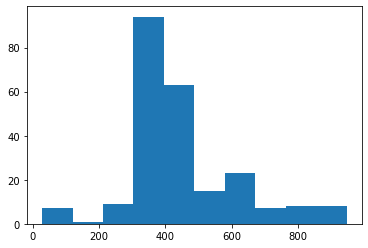

In [52]:
plt.hist(df_explore['dateCreacion'])

In [53]:
#df_subset = df_explore.iloc[:,[0,1]]
#df_subtotal = df_explore.iloc[:,-1]
#df_subtotal = pd.concat([df_subset, df_subtotal], axis=1)
#df_subtotal.head()

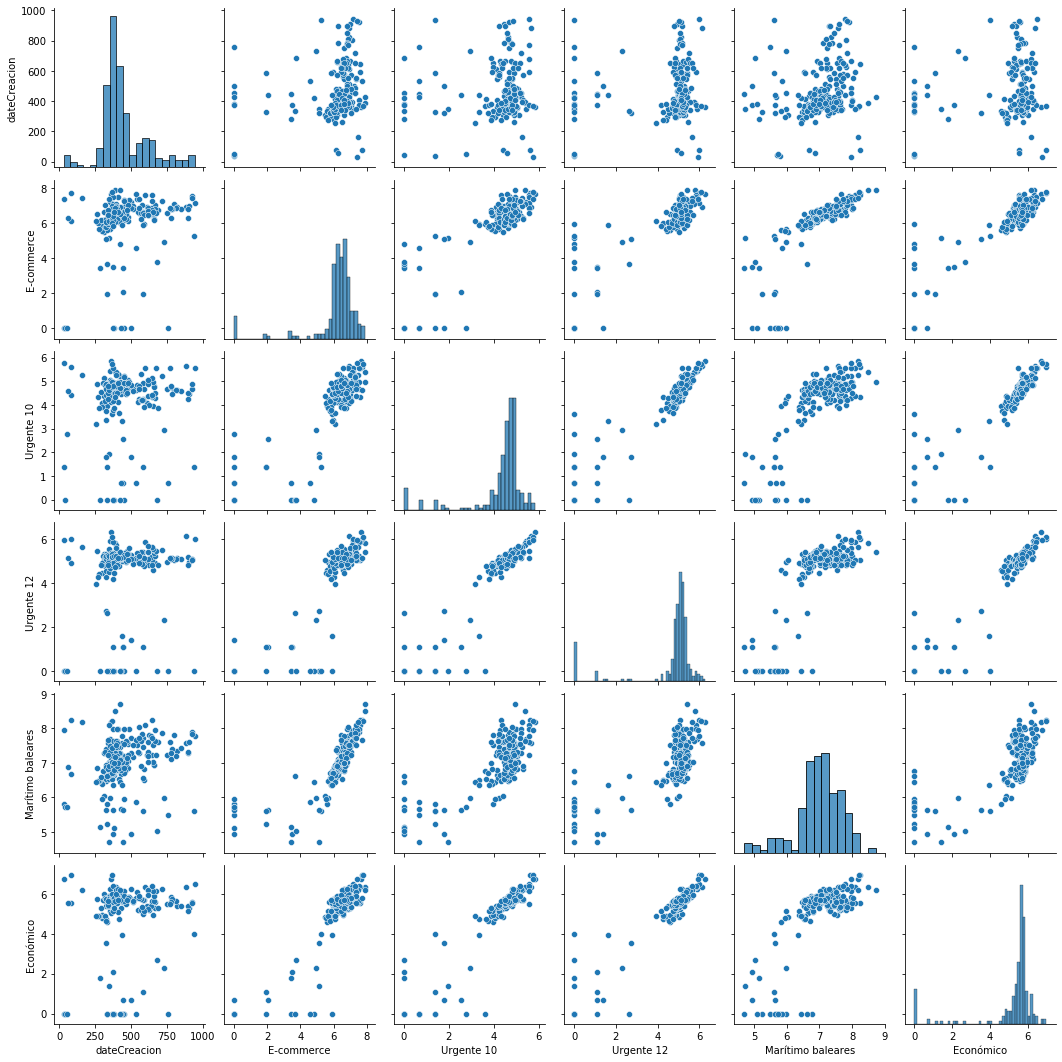

In [54]:
sns.pairplot(df_explore.loc[:,['dateCreacion','E-commerce', 'Urgente 10', 'Urgente 12', 'Marítimo baleares', 'Económico']]);

In [55]:
x = np.array(df_explore['index'])
#envios = np.array(df_explore['total'])
llamadas = np.array(df_explore['dateCreacion'])

'''
envio24h = np.array(df_explore['Urgente 8:30'] + df_explore['Urgente 10'] + df_explore['Urgente 12'] + \
    df_explore['Urgente 14'] + df_explore['Urgente 19'] + df_explore['Urgente 8:30 expedición'] + \
    df_explore['Urgente 10 expedición'] + df_explore['Urgente 12 expedición'] + \
    df_explore['Urgente 19 expedición'] + df_explore['Burofax'] + \
    df_explore['Mascotas'])
'''

envio24h = np.array(df_explore['Urgente 10'] + df_explore['Urgente 12'] + df_explore['Urgente 19'])


envio48h = np.array(df_explore['Económico'] + df_explore['E-commerce'])

'''
minoritarios =  np.array(df_explore['Bag 14'] + df_explore['Bag 19'] + df_explore['Express documentos'] + \
    df_explore['Documentos 14'] + df_explore['Urgente hoy'] +  df_explore['Urgente 14 expedición'] + \
    df_explore['Retorno canje'] + df_explore['Mrw economy (ecopaq)'])

minoritarios =  np.array(df_explore['Bag 19'] + df_explore['Express documentos'] + \
    df_explore['Mrw economy (ecopaq)'])

'''


maritimo = np.array(df_explore['Marítimo baleares'])

In [56]:
def normalizar2(Xs, datos, llamadas):
    mask = datos == 0
    x = np.delete(Xs, mask)
    d1 = np.delete(datos, mask)
    d2 = np.delete(llamadas, mask)
    d1 = np.log(d1)
    d2 = np.log(d2)
    
    return x, d1, d2

def normalizar(Xs, datos, llamadas):
    mask = datos == 0
    x = np.delete(Xs, mask)
    d1 = np.delete(datos, mask)
    d2 = np.delete(llamadas, mask)
    
    return x, d1, d2

In [57]:
'''
Xs, ys1, ys2 = normalizar(x, envios, llamadas)
plt.scatter(Xs, ys1, c='black')
plt.scatter(Xs, ys2, c='blue', alpha=.5);
'''

"\nXs, ys1, ys2 = normalizar(x, envios, llamadas)\nplt.scatter(Xs, ys1, c='black')\nplt.scatter(Xs, ys2, c='blue', alpha=.5);\n"

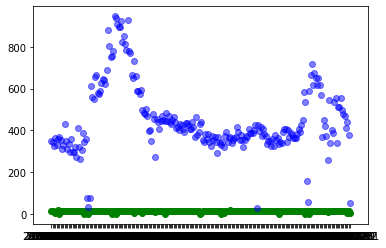

In [58]:
Xs, ys1, ys2 = normalizar(x, envio24h, llamadas)
plt.scatter(Xs, ys1, c='green')
plt.scatter(Xs, ys2, c='blue', alpha=.5);

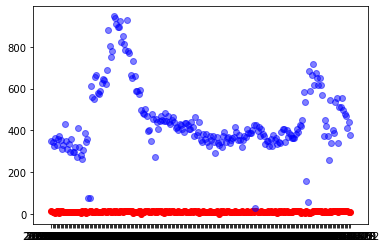

In [59]:
Xs, ys1, ys2 = normalizar(x, envio48h, llamadas)
plt.scatter(Xs, ys1, c='red')
plt.scatter(Xs, ys2, c='blue', alpha=.5);

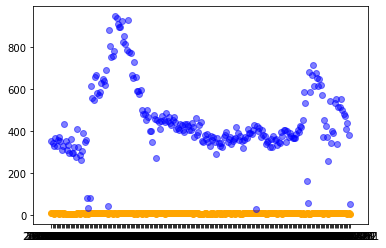

In [60]:
Xs, ys1, ys2 = normalizar(x, maritimo, llamadas)
plt.scatter(Xs, ys1, c='orange')
plt.scatter(Xs, ys2, c='blue', alpha=.5);

In [61]:
'''
Xs, ys1, ys2 = normalizar(x, minoritarios, llamadas)
plt.scatter(Xs, ys1, c='pink')
plt.scatter(Xs, ys2, c='blue', alpha=.5);
'''

"\nXs, ys1, ys2 = normalizar(x, minoritarios, llamadas)\nplt.scatter(Xs, ys1, c='pink')\nplt.scatter(Xs, ys2, c='blue', alpha=.5);\n"

## Modelo

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [63]:
reg = LinearRegression()

In [64]:
#X = df_explore.loc[:,['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']]
X = df_explore.iloc[:,1:-1]
y = df_explore['dateCreacion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [65]:
reg.fit(X_train,y_train)

LinearRegression()

In [66]:
y_pred = reg.predict(X_test)

In [67]:
mean_absolute_error(y_test, y_pred)

94.44903234787675

In [80]:
analisisX = df_explore.iloc[:,-1].reset_index()
analisisX = analisisX['dateCreacion']

analisisPre = reg.predict(X)
analisisPre = pd.DataFrame(analisisPre)
#analisisX, analisisPre

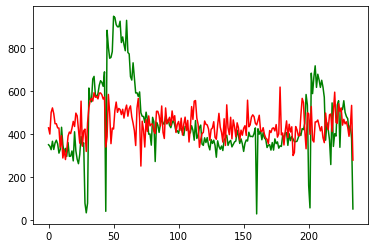

In [69]:
plt.plot(analisisX, c='green')
plt.plot(analisisPre, c='red')

In [70]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [71]:
reg_gs = GridSearchCV(KNeighborsRegressor(),
                        param_grid={"n_neighbors":np.arange(3,50)})

In [72]:
reg_gs.fit(X,y)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [73]:
reg_gs.best_params_, reg_gs.best_score_

({'n_neighbors': 49}, -0.910172036867432)

In [74]:
regk = KNeighborsRegressor(n_neighbors=3)

In [75]:
regk.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=3)

In [76]:
y_predk = regk.predict(X_test)

In [77]:
#MAE
mean_absolute_error(y_test, y_predk)

112.11347517730496

In [78]:
cross_val_score(regk,X,y,scoring='neg_mean_absolute_error').mean()

-124.3304964539007

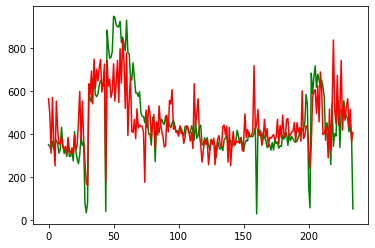

In [79]:
analisisPre = regk.predict(X)
analisisPre = pd.DataFrame(analisisPre)
analisisPre

plt.plot(analisisX, c='green')
plt.plot(analisisPre, c='red')